# Estrategia actual

La estrategia actual de la empresa se divide en 2:

- Por una parte, el cliente puede seleccionar un envío "On Demand", y la empresa se compromete con un envío menor a 90 min.
- Un envío que no es "On Demand" , el cliente debe elegir un rango de horario de 1 hora en la cual puede llegar el pedido.

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import shap
from xgboost import XGBRegressor
from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
from xgboost import plot_importance



plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.set_context("paper")


## Pre / Procesamiento

In [116]:
df = pd.read_csv('data/consolidado.csv')

In [117]:
time = pd.DataFrame(df.entrega.str.split(':', expand=True))
time.columns = ('hora','minuto','segundos')
df['hora'] = pd.to_numeric(time['hora'])
df.rename(columns= {'id_entrega':'on_demand'},inplace=True)
df['promesa_h'] = pd.to_datetime(df['promesa'], format='%H:%M:%S')
df['entrega_h'] = pd.to_datetime(df['entrega'], format='%H:%M:%S')
df['diferencia'] = (df['promesa_h']- df['entrega_h']).dt.total_seconds()/60
df = df.query("abs(diferencia)<1000")
df['tiempo'] = pd.to_numeric(df.tiempo.str.replace('.',''))/1000000
df.drop( df[ df['tiempo'] < 25 ].index , inplace=True)

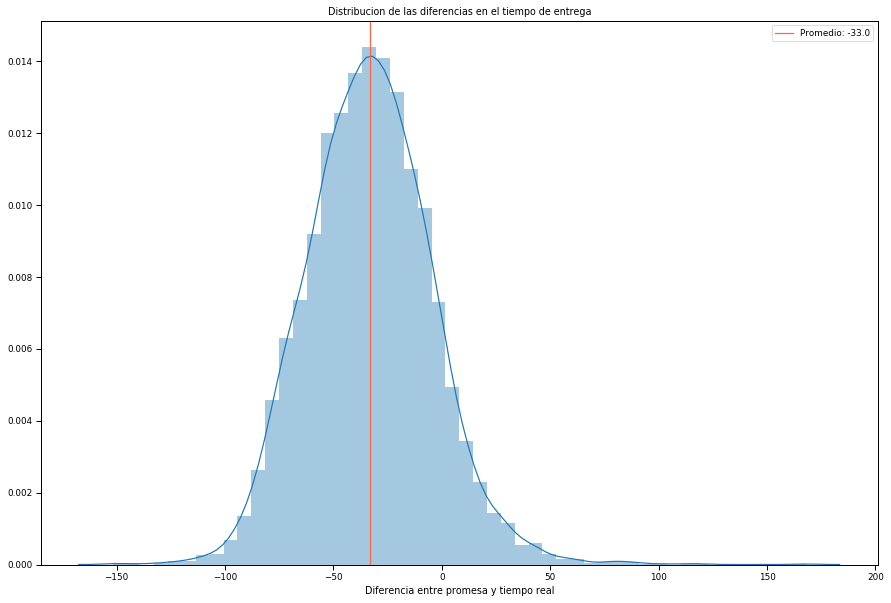

In [118]:
sns.distplot(-df['diferencia'])
plt.axvline(-df['diferencia'].mean(), color="tomato", label='Promedio: '+str(np.round(-df['diferencia'].mean())))
plt.title('Distribucion de las diferencias en el tiempo de entrega')
plt.xlabel('Diferencia entre promesa y tiempo real', )
plt.legend()
plt.show()

La mayor parte de las órdenes llega antes del tiempo máximo prometido, en promedio 33 minutos antes

## La Promesa

Definimos como promesa no cumplida:
- Si la promesa llega después del tiempo estimado
- En el caso del cliente que elige un rango de hora, la promesa se considera incumplida si llega antes de 60 minutos o más del tiempo estimado

In [119]:
df['promesa_cumplida'] = np.where(df['diferencia']<0 , 0, np.where((df['on_demand']== 1)&(df['diferencia']>60),0,1))

In [120]:
df['promesa_cumplida'].value_counts(normalize = True)

1    0.720505
0    0.279495
Name: promesa_cumplida, dtype: float64

La empresa no cumple la promesa en un **28% de los pedidos**

In [121]:
(df.groupby('on_demand')['promesa_cumplida'].value_counts(normalize = False))

on_demand  promesa_cumplida
0          1                   1981
           0                    458
1          1                   2239
           0                   1179
Name: promesa_cumplida, dtype: int64

In [122]:
(df.groupby('on_demand')['promesa_cumplida'].value_counts(normalize = True))

on_demand  promesa_cumplida
0          1                   0.812218
           0                   0.187782
1          1                   0.655061
           0                   0.344939
Name: promesa_cumplida, dtype: float64

Siendo más precisos, hay más propensión a incumplir la promesa cuando **el cliente elige un rango de tiempo**

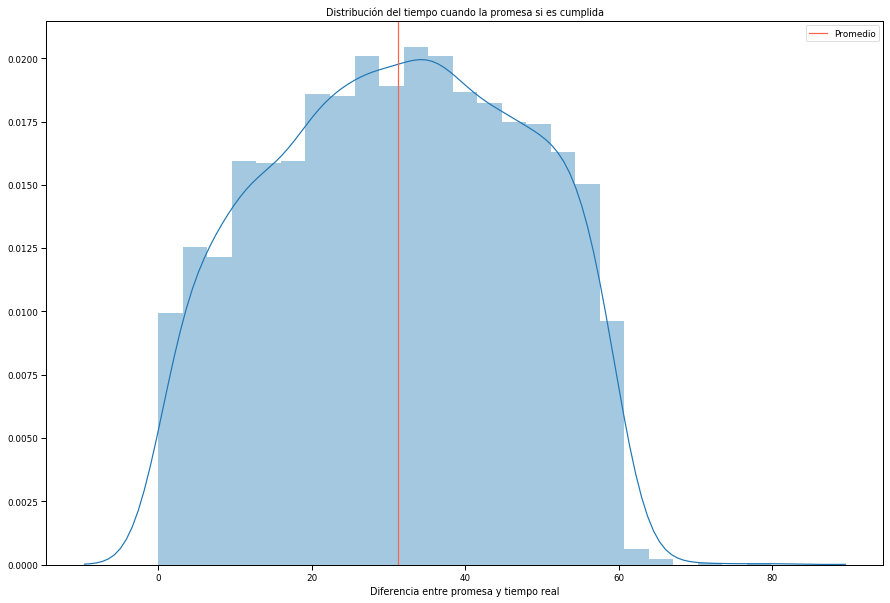

In [123]:
sns.distplot(df[df['promesa_cumplida'] == 1].query("diferencia<1200").diferencia)
plt.axvline(df[df['promesa_cumplida'] == 1].query("diferencia<1200").diferencia.mean(), color="tomato",label='Promedio')
plt.title('Distribución del tiempo cuando la promesa si es cumplida')
plt.xlabel('Diferencia entre promesa y tiempo real', )
plt.legend()
plt.show()

# Incumplimiento promesa por dia/hora

In [124]:
df.groupby('dia')['promesa_cumplida'].mean()

dia
0    0.784912
1    0.706818
2    0.713064
3    0.681685
4    0.724172
5    0.721470
6    0.753968
Name: promesa_cumplida, dtype: float64

In [125]:
df['dia_r']= df.dia.replace({0:'domingo', 1:'lunes', 2:'martes', 3:'miercoles',
                                 4:'jueves', 5:'viernes', 6:'sabado'})

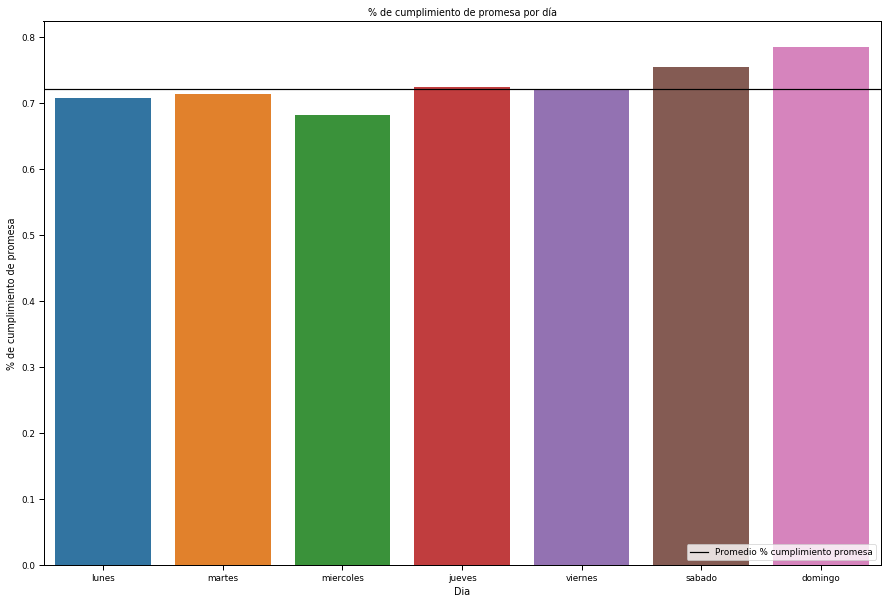

In [126]:
sns.barplot(data= df.groupby('dia_r')['promesa_cumplida'].mean().reset_index(), x='dia_r', y='promesa_cumplida',order=['lunes','martes','miercoles','jueves','viernes','sabado','domingo'])
plt.axhline(df['promesa_cumplida'].mean(), color='black',label = 'Promedio % cumplimiento promesa')
plt.legend(loc ='lower right')
plt.xlabel('Dia')
plt.ylabel('% de cumplimiento de promesa')
plt.title('% de cumplimiento de promesa por día')
plt.show()

Días que están bajo el % de cumplimiento son Lunes, Martes y Miércoles (especialmente este último)

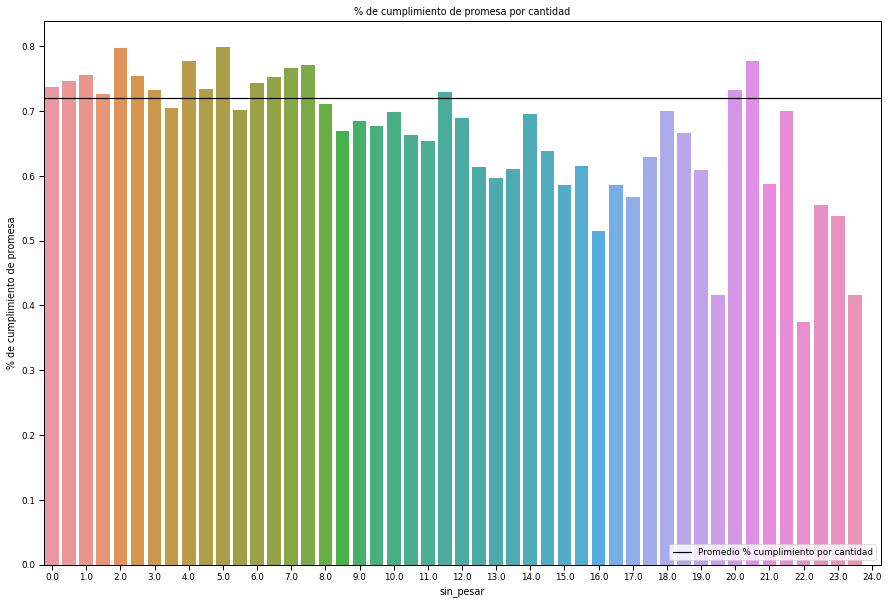

In [127]:


sns.barplot(data= df.query("sin_pesar<49").groupby('sin_pesar')['promesa_cumplida'].mean().reset_index(), x='sin_pesar', y='promesa_cumplida',)
plt.axhline(df['promesa_cumplida'].mean(), color='black',label = 'Promedio % cumplimiento por cantidad')
plt.legend(loc ='lower right')
plt.ylabel('% de cumplimiento de promesa')
plt.title('% de cumplimiento de promesa por cantidad')
plt.xticks(np.arange(0, 49 ,2))

plt.show()



Como notamos, la promesa tiende a no cumplirse mientras mayor es la cantidad de productos

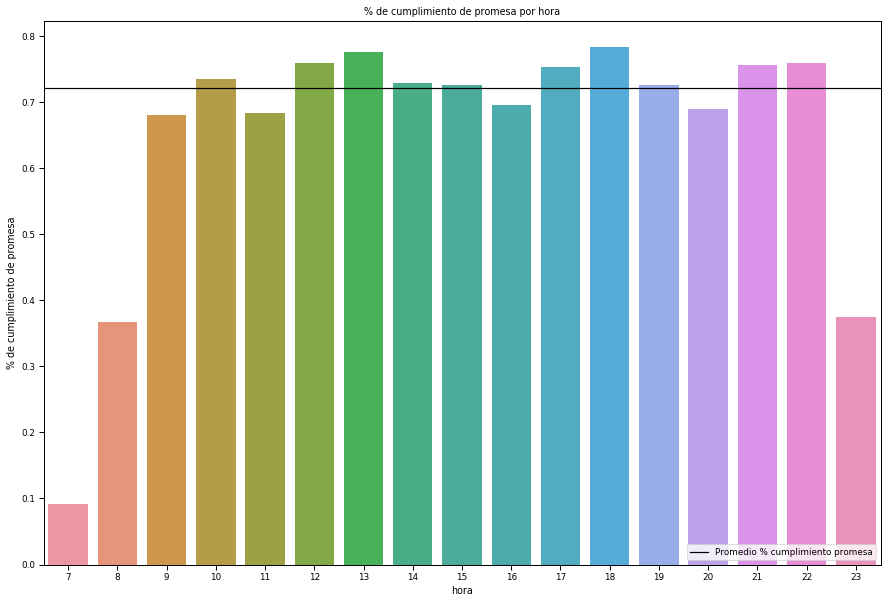

In [128]:
sns.barplot(data= df.groupby('hora')['promesa_cumplida'].mean().reset_index(), x='hora', y='promesa_cumplida',)
plt.axhline(df['promesa_cumplida'].mean(), color='black',label = 'Promedio % cumplimiento promesa')
plt.legend(loc ='lower right')
plt.ylabel('% de cumplimiento de promesa')
plt.title('% de cumplimiento de promesa por hora')
plt.show()



Los horarios que están bajo el promedio de cumplimiento son las 7am, 8am, 9am, 11am, 16pm, 19pm, 20pm y 23pm

In [129]:
pt = df.pivot_table(values='promesa_cumplida', index='hora', columns='dia_r').reindex_axis(['lunes','martes','miercoles','jueves','viernes','sabado','domingo'], axis=1)

/anaconda3/envs/env_full/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


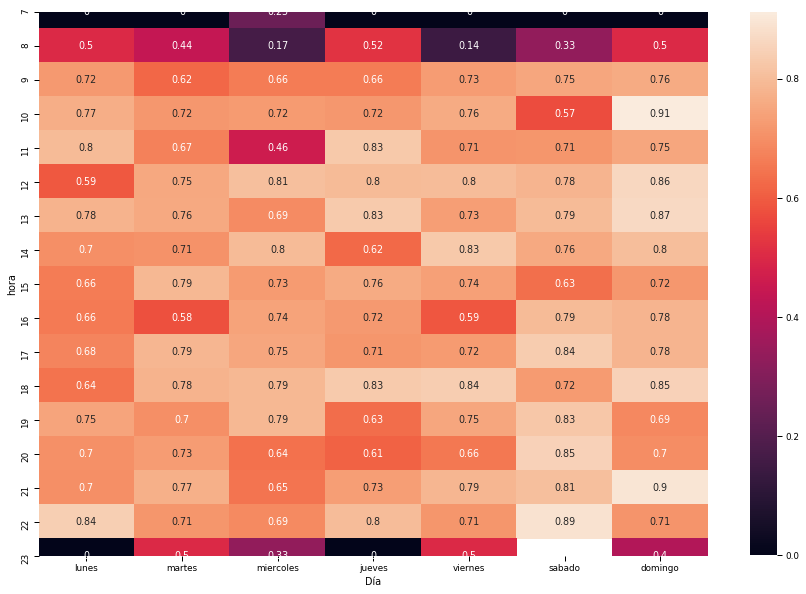

In [130]:
sns.heatmap(pt, annot=True, )
plt.xlabel('Día')
plt.show()

De forma exploratoria, notamos que la mayor parte de los incumplimientos de promesas, ocurren en horarios posteriores a las 20 PM y previos a las 10 AM. También hay ciertas franjas de tiempo que tienen un bajo cumplimiento, tal como el lunes de 15 a 18 hrs, el miércoles de 20 a 22 hrs, el viernes a las 16hrs y elsabado a als 15 hrs.

In [131]:
df['franjas_horarias'] = np.where(df.hora < 12, 'AM', np.where(df.hora < 18, 'PM-1', 'PM-2'))

In [132]:
pt_2 = df.pivot_table(values='promesa_cumplida', index='franjas_horarias', columns='dia_r').reindex_axis(['AM','PM-1','PM-2'], axis=0).reindex_axis(['lunes','martes','miercoles','jueves','viernes','sabado','domingo'], axis=1)

/anaconda3/envs/env_full/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


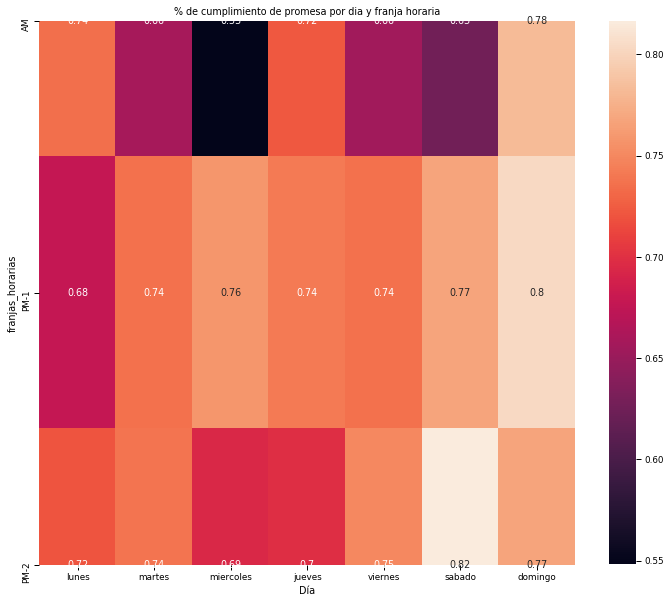

In [133]:
plt.figure(figsize=(12, 10))
sns.heatmap(pt_2, annot=True, )
plt.xlabel('Día')
plt.title('% de cumplimiento de promesa por dia y franja horaria')
plt.show()

# Analisis Modelo XGBoost "on_demand" = 0

In [134]:
import sklearn

In [135]:
import shap
from sklearn.ensemble import GradientBoostingRegressor

In [136]:
df_sinimp = pd.read_csv('data/df_sin_imput.csv').drop(columns='Unnamed: 0')

In [137]:
df_1 = df_sinimp.query("id_entrega==1")
df_0 = df_sinimp.query("id_entrega==0")

In [138]:
df_1x = df_1.drop(columns='tiempo')
df_1y = df_1['tiempo']
df_0x = df_0.drop(columns='tiempo')
df_0y = df_0['tiempo']

In [139]:
xgb = XGBRegressor(nthread=-1, silent = True, random_state=16356)

In [140]:
names = df_0x.columns

In [141]:
df_0x.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']

In [142]:
mod_best_xgb = xgb.fit(df_0x, df_0y)
mod_best_xgb_predict = xgb.predict(df_0x)

/anaconda3/envs/env_full/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/env_full/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [143]:
y_pred = xgb.predict(df_0x)
y_pred.mean()

76.39006

In [144]:
df_0x.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']

In [145]:
print(partial_dependence(mod_best_xgb, features=[1], X=df_0x,         grid_resolution=15) )

(array([[ 61.394306,  65.509926,  65.509926,  71.541374,  73.50466 ,
         75.79453 ,  75.76694 ,  80.2883  ,  84.864044,  85.78443 ,
         92.56814 ,  92.56814 ,  94.99547 , 101.62227 , 101.619354]],
      dtype=float32), [array([ 1.        ,  2.57142857,  4.14285714,  5.71428571,  7.28571429,
        8.85714286, 10.42857143, 12.        , 13.57142857, 15.14285714,
       16.71428571, 18.28571429, 19.85714286, 21.42857143, 23.        ])])


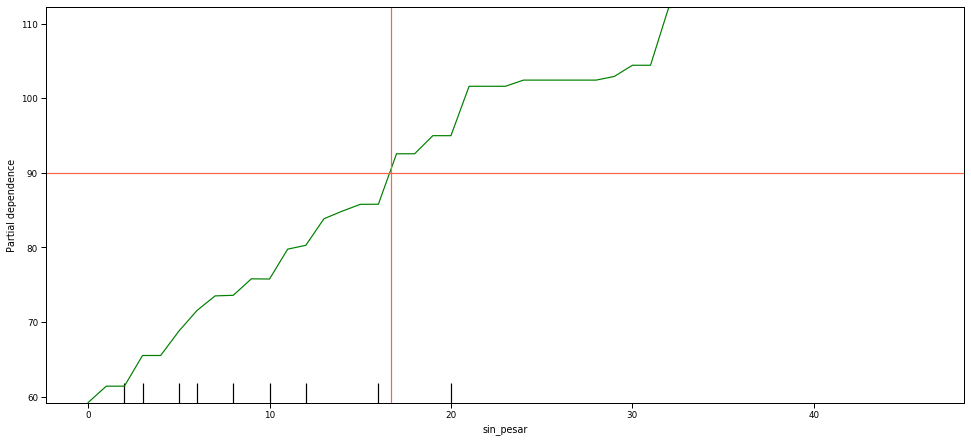

In [146]:
plot_partial_dependence(mod_best_xgb, df_0x, features= [1], feature_names=names)

plt.axvline(16.7, color='tomato')
plt.axhline(90, color='tomato')

Notamos que en el caso de los envios "on_demand", notamos que sobre 17 productos sin pesar el tiempo supera los  90 minutos, por lo que definiremos una nueva estrategia 

**Envíos Express:**
- Aquellos envios que se requieran en menos de 90 minutos, deben tener menos de 17 productos, en caso contrario, el pedido llegará en menos de 120 minutos.

# Analisis Modelo XGBoost "on_demand" = 1, **Franja Horaria**

In [147]:
xgb = XGBRegressor(nthread=-1, silent = True, random_state=16356)

In [148]:
names = df_1x.columns
mod_best_xgb = xgb.fit(df_1x, df_1y)
mod_best_xgb_predict = xgb.predict(df_1x)
y_pred = xgb.predict(df_1x)


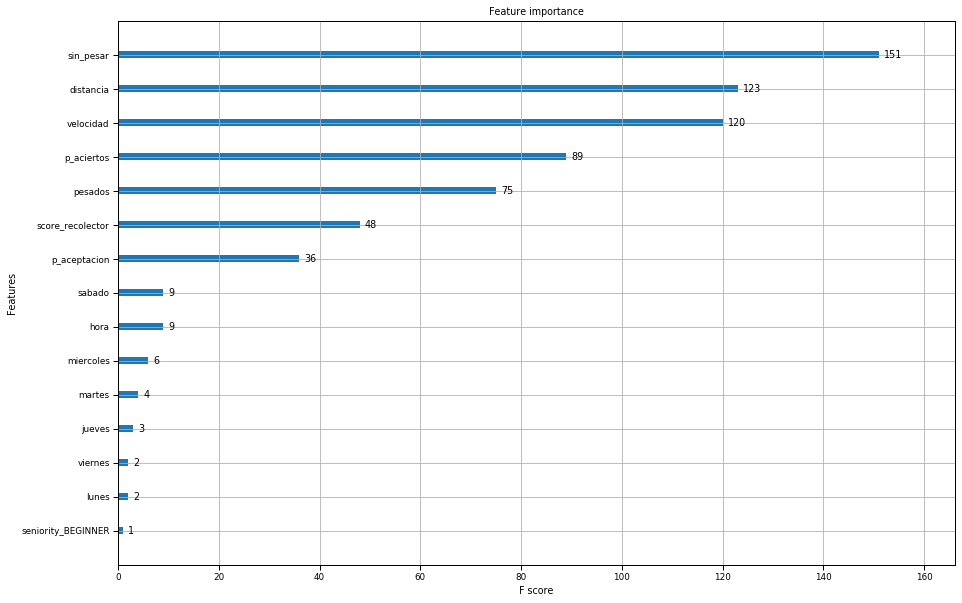

In [150]:
plot_importance(xgb,)

En este caso, la definición de la estrategia es diferente, dado que el tiempo de  entrega, esta muy enlazado al momento en que se le asigna la orden a un recolector, de todas forma podemos revisar si hay alguna variable que afecte al modelo e intervenir la estrategia en ese punto para lograr un mejor cumplimiento de la promesa.
De todas formas, confiamos que la aplicación de este modelo al momento de hacer la asignación del recolector al pedido, disminuirá el error de manera considerable, pero no es medible  con los datos que tenemos en estos momentos.

In [151]:
#df_1x.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']


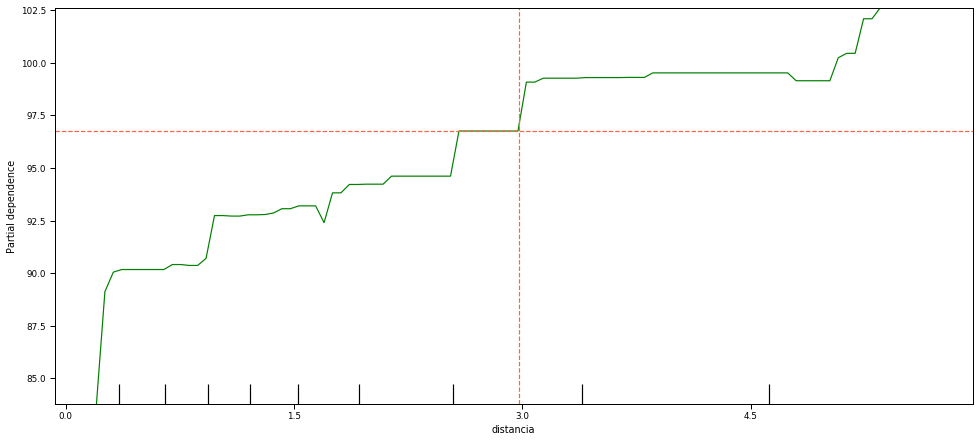

In [152]:
df_1x.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17']

mod_best_xgb = xgb.fit(df_1x, df_1y)
mod_best_xgb_predict = xgb.predict(df_1x)
y_pred = xgb.predict(df_1x)
y_pred.mean()
plot_partial_dependence(mod_best_xgb, df_1x, features= [10], feature_names=names)
plt.axvline(2.98, color='tomato', ls='--')
plt.axhline(96.768, color='tomato', ls='--')



Elegimos la segunda variable que más impacta al modelo, la distancia.
En este caso, notamos que una distancia mayor a 3 kms impacta de forma considerable los tiempos de entrega, por lo que podemos definir una estrategia 
- En caso de que el pedido se elija en una ienda de una distancia mayor a 3kms al lugar de entrega, la franja horaria es de 1.30h en vez de 1h

# Cálculo estrategia

Definimos la nueva estrategia: 

**Envíos Express:**
- Aquellos envios que se requieran en menos de 90 minutos, deben tener menos de 17 productos, en caso contrario, el pedido llegará en menos de 120 minutos.

**Tiempo por distancia**
- En caso de que el pedido se elija en una ienda de una distancia mayor a 3kms al lugar de entrega, la franja horaria es de 1.30h en vez de 1h

In [153]:
df['on_demand_extend'] = np.where((df['on_demand']==0)&(df['sin_pesar']>16),1,0)

df['promesa_extendida']  = np.where((df['on_demand_extend']==1)&(-df['diferencia']<30),1,0)

df['hora_peak'] = df_sinimp['hora']

df['distancia'] = df_sinimp['distancia']

df['nueva_promesa'] = np.where((df['distancia']>3)&(df['on_demand']==1)&(-df['diferencia']<15)&(-df['diferencia']>-75),1,0)

df['promesa_nuevaestrategia'] = np.maximum(df.nueva_promesa, (np.maximum(df['promesa_cumplida'], df['promesa_extendida'])))

In [154]:
(df.groupby('on_demand')['promesa_cumplida'].value_counts(normalize = True))

on_demand  promesa_cumplida
0          1                   0.812218
           0                   0.187782
1          1                   0.655061
           0                   0.344939
Name: promesa_cumplida, dtype: float64

In [155]:
(df.groupby('on_demand')['promesa_nuevaestrategia'].value_counts(normalize = True))

on_demand  promesa_nuevaestrategia
0          1                          0.849938
           0                          0.150062
1          1                          0.700117
           0                          0.299883
Name: promesa_nuevaestrategia, dtype: float64

In [156]:
df.groupby('on_demand')[['promesa_cumplida','promesa_nuevaestrategia']].mean().round(2)

,promesa_cumplida,promesa_nuevaestrategia
on_demand,,
0,0.81,0.85
1,0.66,0.70


Tal como vemos en la tabla anterior, esta nueva estategia hace crecer el % de cumplimiento de la promesa en **4 pp.**  tanto en el caso de on_demand como en el caso de franja horaria

In [157]:
abs(y_pred -df_1y).mean()

15.84305216608797

# Implementación modelo en el flujo de asignación de recolectores

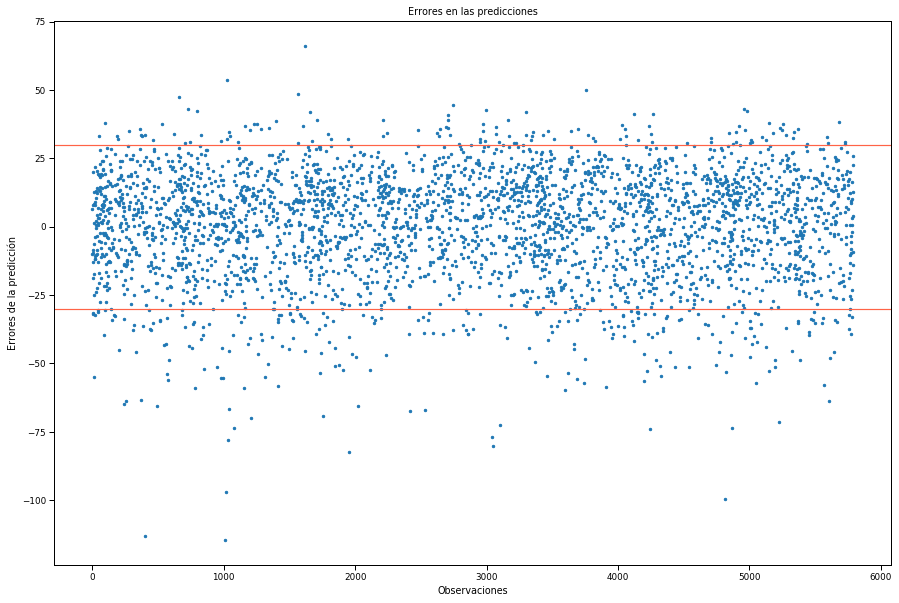

In [158]:
plt.plot(y_pred -df_1y, marker='.', ls=''),
plt.ylabel("Errores de la predicción")
plt.xlabel('Observaciones')
plt.title("Errores en las predicciones")
plt.axhline(30, color='tomato')
plt.axhline(-30, color='tomato')
plt.show()

In [159]:
np.where(abs(y_pred -df_1y) <=30,1,0).mean()

0.8839811542991755

Si consideramos que un 88% de nuestras predicciones tienen un error menor a 30 minutos (pueden llegar 30 min antes o después), para el caso de aquellos que son elegidos en franja horaria, al momento de asignar recolector podemos considerar que nuestro horario a hacer la entrega es el punto medio de la franja. *(Ej: Si el rango es entre 10.00am y 11.00am, nuestro horario objetivo a hacer la entrega es 10.30am).*  
Si al momento de hacer la asignación, consideramos los tiempos predichos por nuestro modelo, se puede elegir al recolector adecuado, y un 88% de las promesas serían cumplidas. Esto es dado que un 88% de las veces llegaría 30min tarde o 30 minutos antes, y de cualquier manera, la promesa se cumpliría.

EL modelo se encuentra serializado y sería necesario incluirlo dentro del flujo de asignación de shopper de la empresa

# Otros puntos

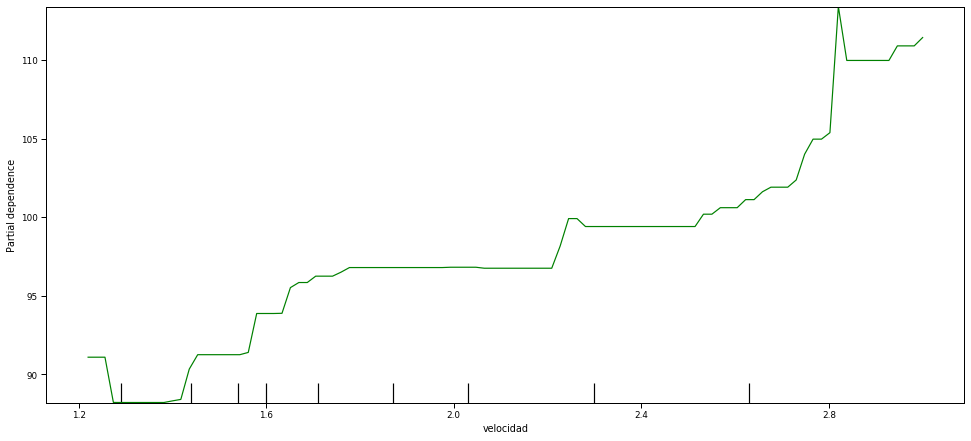

In [190]:
plot_partial_dependence(mod_best_xgb, df_1x, features= [4], feature_names=names,)



Obviamente la velocidad promedio de compra de un repartidor influye directamente en el tiempo de entrega, por lo que la empresa podría generar un programa de incentivos en el cual  premie a aquellos que tengan una alta velocidad, pero también manteniendo sus puntajes de aceptación, aciertos y score 